# I'll train a model to tell birds from airplanes

First let s import the dataset

In [1]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
cifar10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [3]:
img, label = cifar10[99]
img, label, cifar10.classes[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

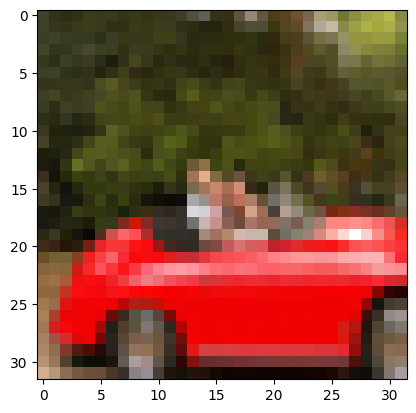

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

Let's see how we can plot the image when it is in a Tensor form:

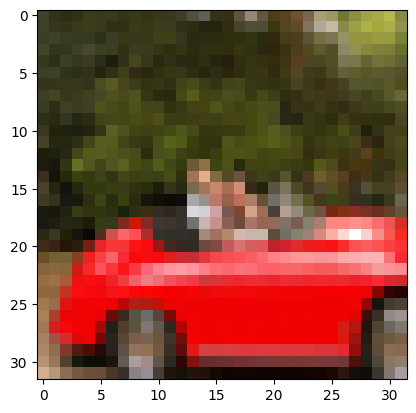

In [8]:
img_t, _ = tensor_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### Normalising the Data

In [22]:
import torch
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

transformed_cifar10 = datasets.CIFAR10(
        data_path, train=True, download=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean,
                std)
        ]))
transformed_cifar10_test = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

Let's plot the normalised image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802377..2.1267893].


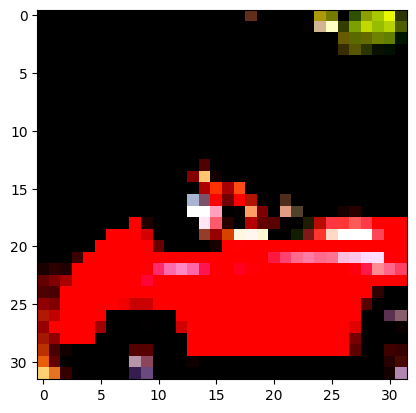

In [23]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Building the dataset

We'll only take the data we need from cifar10, aka the birds and airplanes

In [24]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10
    if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_test
    if label in [0, 2]]

In [25]:
print(len(cifar2))

10000


In [ ]:
import torch.nn as nn

n_out = 2
model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),    # Activation func
        nn.Linear(512, n_out),
        nn.Softmax(dim=1)   # Softmax for output layed
    )

In [28]:
img, _ = cifar2[0]
img.permute(1, 2, 0)
img_batch = img.view(-1).unsqueeze(0)
model(img_batch)

tensor([[0.3832, 0.6168]], grad_fn=<SoftmaxBackward0>)

We'll use NLL Loss for this task

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

loss_fn = nn.NLLLoss()

In [31]:
import torch.optim as optim

learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Let's train the model:

In [34]:
loss_fn = nn.NLLLoss()
n_epochs = 10
loss_array = []
for epoch in range(n_epochs):
    loss_sum = 0
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        loss_sum += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = loss_sum / len(cifar2)
    print("Epoch: %d, Loss: %f" % (epoch, float(mean_loss)))
    loss_array.append(float(mean_loss))

Epoch: 0, Loss: 1.382721
Epoch: 1, Loss: 1.320361
Epoch: 2, Loss: 1.240681
Epoch: 3, Loss: 1.271779
Epoch: 4, Loss: 1.279739
Epoch: 5, Loss: 1.192161
Epoch: 6, Loss: 1.200479
Epoch: 7, Loss: 1.218725
Epoch: 8, Loss: 1.202572
Epoch: 9, Loss: 1.195533


Let's see how the loss evolved in time

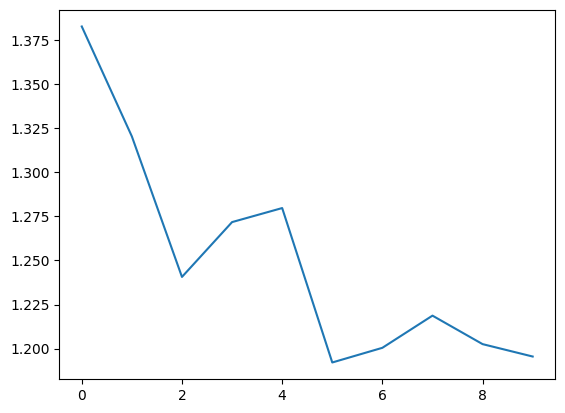

In [35]:
import matplotlib.pyplot as plt

plt.plot(loss_array)

Okay let's test the model

In [50]:
model.eval()

test_loss = 0.0
correct   = 0

i = 0
with torch.no_grad():
    for img, label in cifar2_val:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        test_loss += float(loss)

        probs = out.exp()
        pred = torch.argmax(probs, dim=1)
        confidence = probs[0, pred].item()

        if (pred.item() == label) and (confidence > 0.5):
            correct += 1
        
        i += 1
        if i < 5:
            print(label, pred.item(), confidence)

n_samples   = len(cifar2_val)
avg_loss    = test_loss / n_samples
accuracy    = (correct / n_samples) * 100

print(f"Test set: Average loss: {avg_loss}, Accuracy: {correct}/{n_samples} ({accuracy}%)")

0 1 0.9994809031486511
0 0 0.8410491943359375
0 1 0.9687811136245728
1 1 0.9999997615814209
Test set: Average loss: 1.4396202149677195, Accuracy: 1301/2000 (65.05%)
